In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import argparse
from collections import OrderedDict

import yaml
import csv
import time
from datetime import datetime
import shutil
import logging
from typing import Tuple, Sequence, Any, Union
from functools import partial

from jax import random
import jax.numpy as jnp
import jax
from brax.io import html
from brax import jumpy as jp
from brax import envs
from IPython.display import HTML

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import evojax
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from flax.struct import dataclass
from flax import linen as nn

from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager
import mediapy as media

sns.set_style('darkgrid')
sns.set_palette('muted', desat=.6)
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

output_dir = '/home/floyed/evojax/examples/metaplasticity_plot'

In [12]:
def load_model(model_dir: str) -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    model_file = os.path.join(model_dir, 'best.npz')
    if not os.path.exists(model_file):
        raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

### Temporal Injury

In [105]:
def eval_with_injury(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True, seed=42, injury_ratio=0.):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
        rollout.append(task_state)
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.

        if injury_ratio != 0:
            num_zeros = int(injury_ratio * np.prod(policy_state.fast_Ws[1].shape))
            # random_indices = np.random.choice(policy_state.fast_Ws[1].shape[0], num_zeros, replace=False)
            tmp = np.array(policy_state.fast_Ws[1])
            random_indices = np.random.choice(tmp.size, num_zeros, replace=False)
            tmp.flat[random_indices] *= 0
            policy_state.fast_Ws[1] = jnp.array(tmp)

        if step > 500 and step < 550 and injury:
            policy_state.fast_Ws[1] *= 0
            policy_state.fast_Ws[0] *= 0

        if hasattr(policy_state, 'fast_Ws'):
            ws.append(policy_state.fast_Ws)
        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act[0])
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.

        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    ww = []
    if ws:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = jnp.concatenate(w)
            # print(w.shape)
            if plot:
                media.show_video(w, height=w.shape[1] * 4, codec='gif', fps=5)
                media.write_video(os.path.join(output_dir, '{}.gif'.format(i)), w, codec='gif', fps=5)
                fig, ax = plt.subplots()
                ax.plot(rewards)
            ww.append(w)

    return rewards, rollout, ww


def eval_with_injury_base(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True, seed=42, injury_ratio=0.):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
        rollout.append(task_state)
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        if injury_ratio != 0:
            num_zeros = int(injury_ratio * params.shape[0])
            random_indices = np.random.choice(params.shape[0], num_zeros, replace=False)
            params[random_indices] *= 0

        if step > 500 and step < 550 and injury:
            params *= 0
            # policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act)
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    if plot:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
            # TODO: w

        html.save_html(os.path.join(output_dir, 'eval_with_injury_{}.html'.format(target)), env.sys, [s.qp for s in rollout])

        fig, ax = plt.subplots()
        ax.plot(rewards)
        plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))

    return rewards, rollout

In [14]:
env_names = ['ant_dir', 'halfcheetah_vel', 'ur5e']
num_tasks = 8
hidden_dims = [128]

resume_meta = [
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230622-192221',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225',
#     '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-fetch-ABCD-20230622-212210',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ur5e-ABCD-20230622-192216',
]

resume_base = [
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608',
    # '/data/floyed/meta/train/PGPE-MLPSnnPolicy-swimmer_dir--20230622-113637',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532',
    # '/data/floyed/meta/train/PGPE-MLPSnnPolicy-hopper_vel--20230622-113649',
#     '/data/floyed/meta/train/PGPE-MLPSnnPolicy-fetch--20230622-132230',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ur5e--20230622-113621',
]

In [52]:
targets = [0, 5, None]
y_bases, y_metas = [], []

df = pd.DataFrame(columns=['step', 'Method', 'Env', 'Reward', 'seed'], index=[0, 1, 2, 3, 4])

for seed in range(41, 46):
    for idx, env in enumerate(env_names):
        print(env)
        train_task = BraxTask(
            env_name=env,
            test=False,
            num_tasks=num_tasks
            # terminate_when_unhealthy=args.terminate_when_unhealthy
        )
        policy_meta = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
            input_dim=train_task.obs_shape[0],
            hidden_dims=[
                *hidden_dims,
            ],
            output_dim=train_task.act_shape[0],
        )

        policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
            input_dim=train_task.obs_shape[0],
            hidden_dims=[
                *hidden_dims,
            ],
            output_dim=train_task.act_shape[0],
        )

        meta_best_params, meta_obs_params, meta_epoch, meta_best_score, meta_steps = load_model(model_dir=resume_meta[idx])
        base_best_params, base_obs_params, base_epoch, base_best_score, base_steps = load_model(model_dir=resume_base[idx])
        meta_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)
        base_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

        x, y_meta, y_base = [], [], []
        if targets[idx] is None:
            meta_rewards, meta_rollout, _ = \
                eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target=None, injury=True, plot=False, seed=seed)
            base_rewards, base_rollout = \
                eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target=None, injury=True, plot=False, seed=seed)
            y_metas.append(meta_rewards)
            y_bases.append(base_rewards)

        else:
            _target = targets[idx]
            meta_rewards, meta_rollout, _ = \
                eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target={train_task.task_kwargs: _target}, injury=True, plot=False, seed=seed)
            base_rewards, base_rollout = \
                eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target={train_task.task_kwargs: _target}, injury=True, plot=False, seed=seed)
            y_metas.append(meta_rewards)
            y_bases.append(base_rewards)

        # 'step', 'Method', 'Env', 'Reward', 'seed'
        for j in range(len(meta_rewards)):
            df.loc[len(df.index)] = [j, '$Opt_{Plasticity}$', env, float(meta_rewards[j]), seed]

        for j in range(len(meta_rewards)):
            df.loc[len(df.index)] = [j, '$Opt_{Weight}$', env, float(base_rewards[j]), seed]

ant_dir


MLPPolicy: 2023-07-09 16:36:37,311 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5059.42919921875
(1, 1) (1, 27)
[Eval with injury] rollout reward = 993.8524780273438
halfcheetah_vel


MLPPolicy: 2023-07-09 16:37:00,212 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
(1, 1) (1, 18)
[Eval with injury] rollout reward = -907.4410400390625
(1, 1) (1, 18)
[Eval with injury] rollout reward = -3510.440185546875
ur5e


MLPPolicy: 2023-07-09 16:37:21,416 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 98.31632232666016
(1, 0) (1, 66)
[Eval with injury] rollout reward = 6.105316638946533
ant_dir


MLPPolicy: 2023-07-09 16:37:37,284 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5035.8349609375
(1, 1) (1, 27)
[Eval with injury] rollout reward = 995.6484375
halfcheetah_vel


MLPPolicy: 2023-07-09 16:38:00,242 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
(1, 1) (1, 18)
[Eval with injury] rollout reward = -871.4852905273438
(1, 1) (1, 18)
[Eval with injury] rollout reward = -3336.85546875
ur5e


MLPPolicy: 2023-07-09 16:38:22,145 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 98.92675018310547
(1, 0) (1, 66)
[Eval with injury] rollout reward = 5.162450790405273
ant_dir


MLPPolicy: 2023-07-09 16:38:37,498 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5093.2158203125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 994.3436279296875
halfcheetah_vel


MLPPolicy: 2023-07-09 16:39:01,268 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2883.739501953125
(1, 1) (1, 18)
[Eval with injury] rollout reward = -3408.0458984375
ur5e


MLPPolicy: 2023-07-09 16:39:23,018 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 107.95719146728516
(1, 0) (1, 66)
[Eval with injury] rollout reward = 10.299042701721191
ant_dir


MLPPolicy: 2023-07-09 16:39:39,139 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
(1, 1) (1, 27)
[Eval with injury] rollout reward = 4954.56298828125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 992.6898193359375
halfcheetah_vel


MLPPolicy: 2023-07-09 16:40:02,636 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
(1, 1) (1, 18)
[Eval with injury] rollout reward = -970.406982421875
(1, 1) (1, 18)
[Eval with injury] rollout reward = -3463.317138671875
ur5e


MLPPolicy: 2023-07-09 16:40:24,642 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 103.90849304199219
(1, 0) (1, 66)
[Eval with injury] rollout reward = 11.315604209899902
ant_dir


MLPPolicy: 2023-07-09 16:40:41,110 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
(1, 1) (1, 27)
[Eval with injury] rollout reward = 4990.08349609375
(1, 1) (1, 27)
[Eval with injury] rollout reward = 773.6484985351562
halfcheetah_vel


MLPPolicy: 2023-07-09 16:41:04,648 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
(1, 1) (1, 18)
[Eval with injury] rollout reward = -864.0022583007812
(1, 1) (1, 18)
[Eval with injury] rollout reward = -4334.0537109375
ur5e


MLPPolicy: 2023-07-09 16:41:26,878 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 102.19034576416016
(1, 0) (1, 66)
[Eval with injury] rollout reward = 2.963571310043335


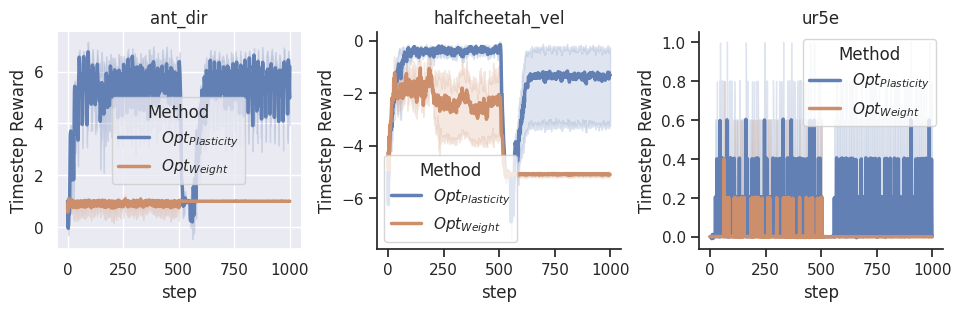

In [53]:
fig = plt.figure(figsize=(9.5 ,3), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=1, ncols=3, figure=fig)  #, width_ratios=[.2, 1, 1, 1, 1, .08, 1.6], height_ratios=[0.02, 1, 1, 0.01])

df = df.dropna()

for i in range(3):
    ax = fig.add_subplot(spec[0, i])  # , projection='polar'
    sns.lineplot(data=df[df["Env"].str.contains(env_names[i])], x='step', y='Reward', hue='Method')
    sns.despine()
    # ax.plot(y_metas[i])
    # ax.plot(y_bases[i]) 
    # ax.legend(['$Opt_{Plasticity}$', '$Opt_{Weight}$'])
    # ax.set_xlabel('step')
    ax.set_ylabel('Timestep Reward')
    sns.set_style("ticks")
    ax.set_title(env_names[i])

plt.savefig(os.path.join(output_dir, 'temporal_injury.pdf'), format='pdf', bbox_inches='tight')
plt.show()

#### Weight Vis

MLPPolicy: 2023-07-09 17:29:13,753 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(1, 1) (1, 27)
[Eval with injury] 100, reward:4.247e+02
[Eval with injury] 200, reward:9.876e+02
[Eval with injury] 300, reward:1.544e+03
[Eval with injury] 400, reward:2.109e+03
[Eval with injury] 500, reward:2.668e+03
[Eval with injury] 600, reward:2.842e+03
[Eval with injury] 700, reward:3.388e+03
[Eval with injury] 800, reward:3.946e+03
[Eval with injury] 900, reward:4.501e+03
[Eval with injury] 1000, reward:5.059e+03
[Eval with injury] rollout reward = 5059.42919921875


""


""


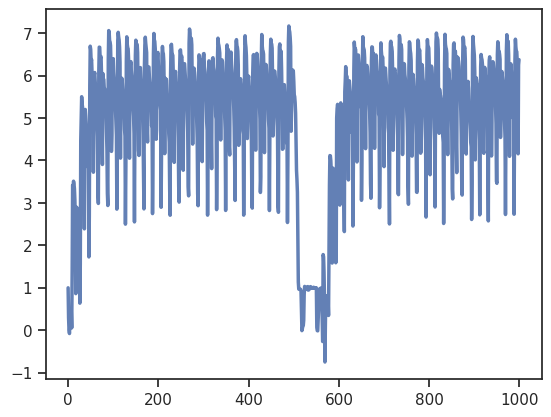

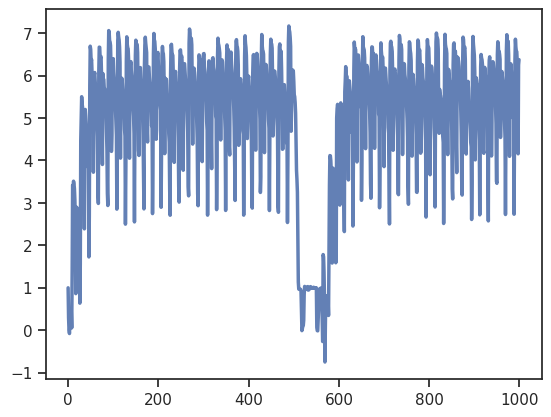

In [106]:
env = 'ant_dir'
train_task = BraxTask(
    env_name=env,
    test=False,
    num_tasks=num_tasks
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)
policy_meta = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

meta_best_params, meta_obs_params, meta_epoch, meta_best_score, meta_steps = load_model(model_dir=resume_meta[0])
meta_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

x, y_meta, y_base = [], [], []

_target = targets[0]
meta_rewards, meta_rollout, ws = \
    eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target={train_task.task_kwargs: _target}, injury=True, plot=True, seed=41)
y_metas.append(meta_rewards)

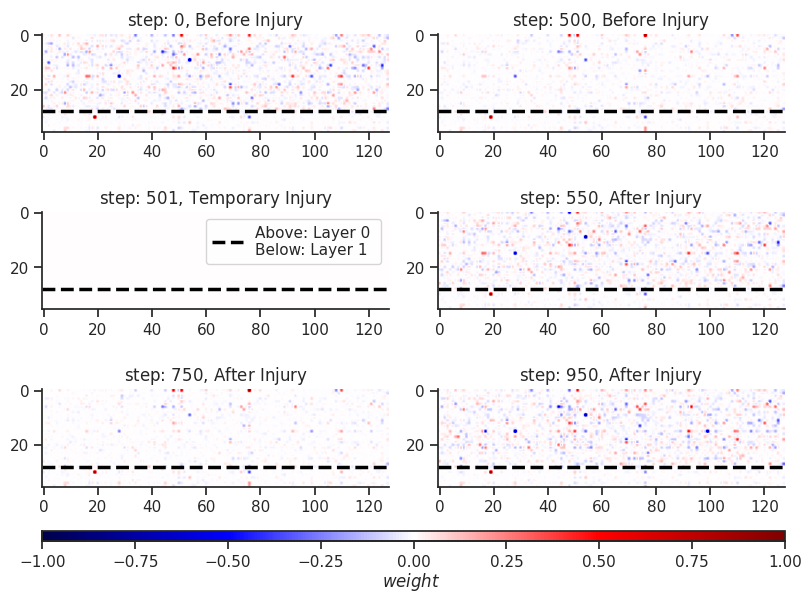

In [184]:
fig = plt.figure(figsize=(8, 6), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=5, ncols=2, figure=fig, height_ratios=[1, 1, 1, .06, .12])

step = [0, 500, 501, 550, 750, 950]
text = ['Before Injury', 'Before Injury', 'Temporary Injury', 'After Injury', 'After Injury', 'After Injury']
for idx in range(6):
    ax = fig.add_subplot(spec[idx // 2, idx % 2])
    w0 = ws[0][step[idx]]
    w1 = ws[1][step[idx]]
    w = np.concatenate([w0, w1.transpose()], axis=0)
    abs_max = max(abs(w.min()), abs(w.max()))
    if abs_max < 1e-5:
        abs_max = 1
    x = plt.imshow(w, vmin=-abs_max, vmax=abs_max, cmap=plt.cm.seismic)
    plt.axhline(28, ls='--', c='k', label='Above: Layer 0 \nBelow: Layer 1')
    plt.title('step: ${}$, {}'.format(step[idx], text[idx]))
    sns.despine()
    sns.set_style("ticks")
    if idx == 2:
        plt.legend()

ax = fig.add_subplot(spec[-2, :])
fig.colorbar(x, cax=ax, orientation="horizontal")
sns.despine(ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.text(0.47, 0.02, '$weight$', va='center')  #, rotation='vertical'

plt.savefig(os.path.join(output_dir, 'temporal_weight_vis.pdf'))

### LifeLong Injury

In [7]:
targets = [2, None, None]
env_names = ['halfcheetah_vel', 'fetch', 'ur5e']
num_tasks = 8
hidden_dims = [128]

resume_meta = [
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-fetch-ABCD-20230623-143515',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ur5e-ABCD-20230622-192216',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230622-192221',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225',
#     '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-fetch-ABCD-20230622-212210',

]

resume_base = [
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-fetch--20230622-132230',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ur5e--20230622-113621',
    # '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608',
    # '/data/floyed/meta/train/PGPE-MLPSnnPolicy-swimmer_dir--20230622-113637',
    # '/data/floyed/meta/train/PGPE-MLPSnnPolicy-hopper_vel--20230622-113649',
]

In [8]:

y_bases, y_metas = [], []
df = pd.DataFrame(columns=['ratio', 'Method', 'Env', 'Reward', 'seed'], index=[0, 1, 2, 3, 4])

# env_names = ['ant_dir', 'halfcheetah_vel', 'ur5e']
for seed in range(41, 46):
    for idx, env in enumerate(env_names):
        print(env)
        train_task = BraxTask(
            env_name=env,
            test=False,
            num_tasks=num_tasks
            # terminate_when_unhealthy=args.terminate_when_unhealthy
        )
        policy_meta = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
            input_dim=train_task.obs_shape[0],
            hidden_dims=[
                *hidden_dims,
            ],
            output_dim=train_task.act_shape[0],
        )

        policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
            input_dim=train_task.obs_shape[0],
            hidden_dims=[
                *hidden_dims,
            ],
            output_dim=train_task.act_shape[0],
        )

        meta_best_params, meta_obs_params, meta_epoch, meta_best_score, meta_steps = load_model(model_dir=resume_meta[idx])
        base_best_params, base_obs_params, base_epoch, base_best_score, base_steps = load_model(model_dir=resume_base[idx])
        meta_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)
        base_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

        x, y_meta, y_base = [], [], []
        ticks = 20
        for ratio in range(ticks):
            r = ratio / ticks
            print(r)
            if targets[idx] is None:
                meta_rewards, meta_rollout = \
                    eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target=None, injury=False, plot=False, seed=seed, injury_ratio=r)
                base_rewards, base_rollout = \
                    eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target=None, injury=False, plot=False, seed=seed, injury_ratio=r)
                y_metas.append(sum(meta_rewards))
                y_bases.append(sum(base_rewards))

            else:
                _target = targets[idx]
                meta_rewards, meta_rollout = \
                    eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False, seed=seed, injury_ratio=r)
                base_rewards, base_rollout = \
                    eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False, seed=seed, injury_ratio=r)
                y_metas.append(sum(meta_rewards))
                y_bases.append(sum(base_rewards))

            # 'step', 'Method', 'Env', 'Reward', 'seed'
            df.loc[len(df.index)] = [r, '$Opt_{Plasticity}$', env, float(sum(meta_rewards)), seed]
            df.loc[len(df.index)] = [r, '$Opt_{Weight}$', env, float(sum(base_rewards)), seed]

halfcheetah_vel


MLPPolicy: 2023-07-04 22:44:27,732 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0.0
(1, 1) (1, 18)
[Eval with injury] rollout reward = -251.3119354248047
(1, 1) (1, 18)
[Eval with injury] rollout reward = -268.13299560546875
0.05
(1, 1) (1, 18)
[Eval with injury] rollout reward = -207.75228881835938
(1, 1) (1, 18)
[Eval with injury] rollout reward = -1956.452392578125
0.1
(1, 1) (1, 18)
[Eval with injury] rollout reward = -336.2724304199219
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2008.504638671875
0.15
(1, 1) (1, 18)
[Eval with injury] rollout reward = -468.7112731933594
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2008.504638671875
0.2
(1, 1) (1, 18)
[Eval with injury] rollout reward = -522.0020751953125
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2008.504638671875
0.25
(1, 1) (1, 18)
[Eval with injury] rollout reward = -702.2468872070312
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2008.504638671875
0.3
(1, 1) (1, 18)
[Eval with injury] rollout reward = -734.1707153320312
(1, 1) (1, 18)
[Eval with injury] 

MLPPolicy: 2023-07-04 22:50:20,078 [INFO] MLPPolicy.num_params = 14346


(101,)
(101,)
0.0
(1, 0) (1, 101)
[Eval with injury] rollout reward = 60.87289047241211
(1, 0) (1, 101)
[Eval with injury] rollout reward = 10.975150108337402
0.05
(1, 0) (1, 101)
[Eval with injury] rollout reward = 60.81317138671875
(1, 0) (1, 101)
[Eval with injury] rollout reward = 3.963432550430298
0.1
(1, 0) (1, 101)
[Eval with injury] rollout reward = 52.783992767333984
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736773490905762
0.15
(1, 0) (1, 101)
[Eval with injury] rollout reward = 54.71358871459961
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736773490905762
0.2
(1, 0) (1, 101)
[Eval with injury] rollout reward = 9.778026580810547
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736773490905762
0.25
(1, 0) (1, 101)
[Eval with injury] rollout reward = 47.88979721069336
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736773490905762
0.3
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.696908473968506
(1, 0) (1, 101)
[Eval with injury] rollout 

MLPPolicy: 2023-07-04 22:57:25,001 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
0.0
(1, 0) (1, 66)
[Eval with injury] rollout reward = 110.56903076171875
(1, 0) (1, 66)
[Eval with injury] rollout reward = 6.145133972167969
0.05
(1, 0) (1, 66)
[Eval with injury] rollout reward = 102.70684814453125
(1, 0) (1, 66)
[Eval with injury] rollout reward = -0.06773631274700165
0.1
(1, 0) (1, 66)
[Eval with injury] rollout reward = 86.76664733886719
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00048061212874017656
0.15
(1, 0) (1, 66)
[Eval with injury] rollout reward = 80.53926849365234
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00048061212874017656
0.2
(1, 0) (1, 66)
[Eval with injury] rollout reward = 63.02499008178711
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00048061212874017656
0.25
(1, 0) (1, 66)
[Eval with injury] rollout reward = 37.04168701171875
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00048061212874017656
0.3
(1, 0) (1, 66)
[Eval with injury] rollout reward = 55.711570739746094
(1, 0) (1, 66)
[Eval wi

MLPPolicy: 2023-07-04 23:01:22,454 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0.0
(1, 1) (1, 18)
[Eval with injury] rollout reward = -242.8163299560547
(1, 1) (1, 18)
[Eval with injury] rollout reward = -257.4693603515625
0.05
(1, 1) (1, 18)
[Eval with injury] rollout reward = -198.8342742919922
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2018.2711181640625
0.1
(1, 1) (1, 18)
[Eval with injury] rollout reward = -295.644287109375
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.2906494140625
0.15
(1, 1) (1, 18)
[Eval with injury] rollout reward = -438.94610595703125
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.2906494140625
0.2
(1, 1) (1, 18)
[Eval with injury] rollout reward = -538.1604614257812
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.2906494140625
0.25
(1, 1) (1, 18)
[Eval with injury] rollout reward = -681.3789672851562
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.2906494140625
0.3
(1, 1) (1, 18)
[Eval with injury] rollout reward = -744.5809326171875
(1, 1) (1, 18)
[Eval with injur

MLPPolicy: 2023-07-04 23:07:08,772 [INFO] MLPPolicy.num_params = 14346


(101,) (10,)
(101,)
(101,)
0.0
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.591758728027344
(1, 0) (1, 101)
[Eval with injury] rollout reward = 11.805059432983398
0.05
(1, 0) (1, 101)
[Eval with injury] rollout reward = 59.97028732299805
(1, 0) (1, 101)
[Eval with injury] rollout reward = 3.6805267333984375
0.1
(1, 0) (1, 101)
[Eval with injury] rollout reward = 56.91556167602539
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367939949035645
0.15
(1, 0) (1, 101)
[Eval with injury] rollout reward = 57.205684661865234
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367939949035645
0.2
(1, 0) (1, 101)
[Eval with injury] rollout reward = 56.23270797729492
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367939949035645
0.25
(1, 0) (1, 101)
[Eval with injury] rollout reward = 33.848724365234375
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367939949035645
0.3
(1, 0) (1, 101)
[Eval with injury] rollout reward = 34.321781158447266
(1, 0) (1, 101)
[Eval 

MLPPolicy: 2023-07-04 23:14:10,272 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
0.0
(1, 0) (1, 66)
[Eval with injury] rollout reward = 109.0873794555664
(1, 0) (1, 66)
[Eval with injury] rollout reward = 5.2074174880981445
0.05
(1, 0) (1, 66)
[Eval with injury] rollout reward = 103.94143676757812
(1, 0) (1, 66)
[Eval with injury] rollout reward = -0.06787079572677612
0.1
(1, 0) (1, 66)
[Eval with injury] rollout reward = 89.4725570678711
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0004731387016363442
0.15
(1, 0) (1, 66)
[Eval with injury] rollout reward = 81.54290008544922
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0004731387016363442
0.2
(1, 0) (1, 66)
[Eval with injury] rollout reward = 60.66794967651367
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0004731387016363442
0.25
(1, 0) (1, 66)
[Eval with injury] rollout reward = 32.98332977294922
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0004731387016363442
0.3
(1, 0) (1, 66)
[Eval with injury] rollout reward = 29.91628646850586
(1, 0) (1, 66)
[Eval with inj

MLPPolicy: 2023-07-04 23:18:06,223 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0.0
(1, 1) (1, 18)
[Eval with injury] rollout reward = -241.4114227294922
(1, 1) (1, 18)
[Eval with injury] rollout reward = -272.5318603515625
0.05
(1, 1) (1, 18)
[Eval with injury] rollout reward = -204.80393981933594
(1, 1) (1, 18)
[Eval with injury] rollout reward = -1925.1077880859375
0.1
(1, 1) (1, 18)
[Eval with injury] rollout reward = -316.3789367675781
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.166748046875
0.15
(1, 1) (1, 18)
[Eval with injury] rollout reward = -422.6136474609375
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.166748046875
0.2
(1, 1) (1, 18)
[Eval with injury] rollout reward = -628.3750610351562
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.166748046875
0.25
(1, 1) (1, 18)
[Eval with injury] rollout reward = -642.1746215820312
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.166748046875
0.3
(1, 1) (1, 18)
[Eval with injury] rollout reward = -748.996337890625
(1, 1) (1, 18)
[Eval with injury] r

MLPPolicy: 2023-07-04 23:23:50,411 [INFO] MLPPolicy.num_params = 14346


(101,) (10,)
(101,)
(101,)
0.0
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.36773681640625
(1, 0) (1, 101)
[Eval with injury] rollout reward = 12.365646362304688
0.05
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.51380920410156
(1, 0) (1, 101)
[Eval with injury] rollout reward = 3.2391462326049805
0.1
(1, 0) (1, 101)
[Eval with injury] rollout reward = 60.72837829589844
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736767768859863
0.15
(1, 0) (1, 101)
[Eval with injury] rollout reward = 55.602054595947266
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736767768859863
0.2
(1, 0) (1, 101)
[Eval with injury] rollout reward = 54.1590690612793
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736767768859863
0.25
(1, 0) (1, 101)
[Eval with injury] rollout reward = 13.940091133117676
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736767768859863
0.3
(1, 0) (1, 101)
[Eval with injury] rollout reward = 51.26211166381836
(1, 0) (1, 101)
[Eval with in

MLPPolicy: 2023-07-04 23:30:49,491 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
0.0
(1, 0) (1, 66)
[Eval with injury] rollout reward = 111.09735870361328
(1, 0) (1, 66)
[Eval with injury] rollout reward = 20.58991241455078
0.05
(1, 0) (1, 66)
[Eval with injury] rollout reward = 111.77212524414062
(1, 0) (1, 66)
[Eval with injury] rollout reward = -0.05834951251745224
0.1
(1, 0) (1, 66)
[Eval with injury] rollout reward = 95.14387512207031
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00037072267150506377
0.15
(1, 0) (1, 66)
[Eval with injury] rollout reward = 76.13178253173828
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00037072267150506377
0.2
(1, 0) (1, 66)
[Eval with injury] rollout reward = 60.75170135498047
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00037072267150506377
0.25
(1, 0) (1, 66)
[Eval with injury] rollout reward = 35.92322540283203
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00037072267150506377
0.3
(1, 0) (1, 66)
[Eval with injury] rollout reward = 52.39390182495117
(1, 0) (1, 66)
[Eval wit

MLPPolicy: 2023-07-04 23:34:47,021 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0.0
(1, 1) (1, 18)
[Eval with injury] rollout reward = -245.8713836669922
(1, 1) (1, 18)
[Eval with injury] rollout reward = -306.5099792480469
0.05
(1, 1) (1, 18)
[Eval with injury] rollout reward = -202.87161254882812
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2157.17626953125
0.1
(1, 1) (1, 18)
[Eval with injury] rollout reward = -325.6309509277344
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.434326171875
0.15
(1, 1) (1, 18)
[Eval with injury] rollout reward = -469.95489501953125
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.434326171875
0.2
(1, 1) (1, 18)
[Eval with injury] rollout reward = -580.7946166992188
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.434326171875
0.25
(1, 1) (1, 18)
[Eval with injury] rollout reward = -595.176513671875
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.434326171875
0.3
(1, 1) (1, 18)
[Eval with injury] rollout reward = -671.1441040039062
(1, 1) (1, 18)
[Eval with injury] ro

MLPPolicy: 2023-07-04 23:40:35,689 [INFO] MLPPolicy.num_params = 14346


(101,) (10,)
(101,)
(101,)
0.0
(1, 0) (1, 101)
[Eval with injury] rollout reward = 60.727783203125
(1, 0) (1, 101)
[Eval with injury] rollout reward = 13.415492057800293
0.05
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.11153793334961
(1, 0) (1, 101)
[Eval with injury] rollout reward = 2.8725664615631104
0.1
(1, 0) (1, 101)
[Eval with injury] rollout reward = 59.46997833251953
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367658615112305
0.15
(1, 0) (1, 101)
[Eval with injury] rollout reward = 55.506019592285156
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367658615112305
0.2
(1, 0) (1, 101)
[Eval with injury] rollout reward = 2.3521504402160645
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367658615112305
0.25
(1, 0) (1, 101)
[Eval with injury] rollout reward = 40.70562744140625
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.7367658615112305
0.3
(1, 0) (1, 101)
[Eval with injury] rollout reward = 34.453147888183594
(1, 0) (1, 101)
[Eval wit

MLPPolicy: 2023-07-04 23:47:36,478 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
0.0
(1, 0) (1, 66)
[Eval with injury] rollout reward = 112.06440734863281
(1, 0) (1, 66)
[Eval with injury] rollout reward = 16.66531753540039
0.05
(1, 0) (1, 66)
[Eval with injury] rollout reward = 106.5919418334961
(1, 0) (1, 66)
[Eval with injury] rollout reward = -0.05000733211636543
0.1
(1, 0) (1, 66)
[Eval with injury] rollout reward = 96.10127258300781
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00035443855449557304
0.15
(1, 0) (1, 66)
[Eval with injury] rollout reward = 83.35970306396484
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00035443855449557304
0.2
(1, 0) (1, 66)
[Eval with injury] rollout reward = 75.24884033203125
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00035443855449557304
0.25
(1, 0) (1, 66)
[Eval with injury] rollout reward = 47.33475112915039
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.00035443855449557304
0.3
(1, 0) (1, 66)
[Eval with injury] rollout reward = 14.476560592651367
(1, 0) (1, 66)
[Eval wit

MLPPolicy: 2023-07-04 23:51:29,265 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0.0
(1, 1) (1, 18)
[Eval with injury] rollout reward = -237.2327880859375
(1, 1) (1, 18)
[Eval with injury] rollout reward = -275.8570556640625
0.05
(1, 1) (1, 18)
[Eval with injury] rollout reward = -211.69842529296875
(1, 1) (1, 18)
[Eval with injury] rollout reward = -1968.478271484375
0.1
(1, 1) (1, 18)
[Eval with injury] rollout reward = -299.10943603515625
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.9183349609375
0.15
(1, 1) (1, 18)
[Eval with injury] rollout reward = -441.8934631347656
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.9183349609375
0.2
(1, 1) (1, 18)
[Eval with injury] rollout reward = -430.60943603515625
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.9183349609375
0.25
(1, 1) (1, 18)
[Eval with injury] rollout reward = -658.39599609375
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2011.9183349609375
0.3
(1, 1) (1, 18)
[Eval with injury] rollout reward = -753.9039916992188
(1, 1) (1, 18)
[Eval with injur

MLPPolicy: 2023-07-04 23:57:10,526 [INFO] MLPPolicy.num_params = 14346


(101,) (10,)
(101,)
(101,)
0.0
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.83796310424805
(1, 0) (1, 101)
[Eval with injury] rollout reward = 13.493847846984863
0.05
(1, 0) (1, 101)
[Eval with injury] rollout reward = 61.90841293334961
(1, 0) (1, 101)
[Eval with injury] rollout reward = 1.9775470495224
0.1
(1, 0) (1, 101)
[Eval with injury] rollout reward = 59.64649963378906
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736771106719971
0.15
(1, 0) (1, 101)
[Eval with injury] rollout reward = 51.497825622558594
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736771106719971
0.2
(1, 0) (1, 101)
[Eval with injury] rollout reward = 41.71296310424805
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736771106719971
0.25
(1, 0) (1, 101)
[Eval with injury] rollout reward = 20.45323944091797
(1, 0) (1, 101)
[Eval with injury] rollout reward = 4.736771106719971
0.3
(1, 0) (1, 101)
[Eval with injury] rollout reward = 27.920063018798828
(1, 0) (1, 101)
[Eval with inju

MLPPolicy: 2023-07-05 00:04:16,540 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
0.0
(1, 0) (1, 66)
[Eval with injury] rollout reward = 110.06404113769531
(1, 0) (1, 66)
[Eval with injury] rollout reward = 2.992966413497925
0.05
(1, 0) (1, 66)
[Eval with injury] rollout reward = 97.70002746582031
(1, 0) (1, 66)
[Eval with injury] rollout reward = -0.06064669042825699
0.1
(1, 0) (1, 66)
[Eval with injury] rollout reward = 94.50894165039062
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0003961156471632421
0.15
(1, 0) (1, 66)
[Eval with injury] rollout reward = 84.1157455444336
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0003961156471632421
0.2
(1, 0) (1, 66)
[Eval with injury] rollout reward = 64.99673461914062
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0003961156471632421
0.25
(1, 0) (1, 66)
[Eval with injury] rollout reward = 43.15078353881836
(1, 0) (1, 66)
[Eval with injury] rollout reward = 0.0003961156471632421
0.3
(1, 0) (1, 66)
[Eval with injury] rollout reward = 33.936378479003906
(1, 0) (1, 66)
[Eval with inj

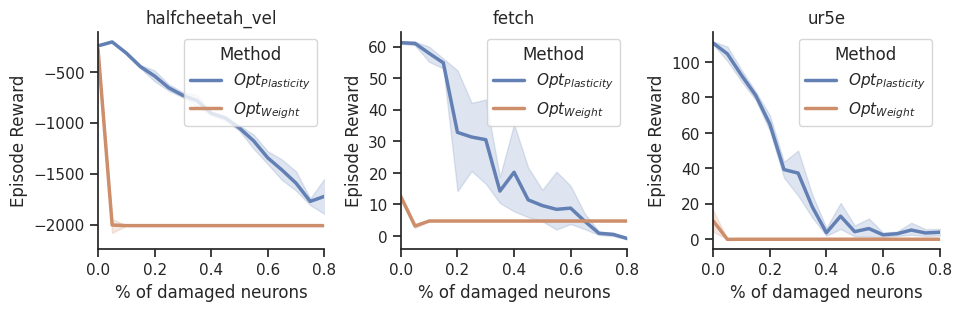

In [9]:
fig = plt.figure(figsize=(9.5, 3), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=1, ncols=3, figure=fig)  #, width_ratios=[.2, 1, 1, 1, 1, .08, 1.6], height_ratios=[0.02, 1, 1, 0.01])

df = df.dropna()

for i in range(3):
    ax = fig.add_subplot(spec[0, i])  # , projection='polar'
    sns.lineplot(data=df[df["Env"].str.contains(env_names[i])], x='ratio', y='Reward', hue='Method')
    sns.despine()
    # ax.plot(y_metas[i])
    # ax.plot(y_bases[i])
    # ax.legend(['$Opt_{Plasticity}$', '$Opt_{Weight}$'])
    # ax.set_xlabel('step')
    ax.set_ylabel('Episode Reward')
    ax.set_xlabel('% of damaged neurons')
    sns.set_style("ticks")
    ax.set_title(env_names[i])
    plt.xlim(0, .8)

plt.savefig(os.path.join(output_dir, 'lifelong_injury.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In [10]:
train_task = BraxTask(
    env_name='halfcheetah_vel',
    test=False,
    num_tasks=num_tasks
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)

policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

base_best_params, base_obs_params, base_epoch, base_best_score, base_steps = load_model(model_dir=resume_base[2])
base_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

rewards, rollout = \
    eval_with_injury_base(policy_base, 'halfcheetah_vel', base_obs_normalizer, base_best_params, base_obs_params, target={train_task.task_kwargs: 2.}, injury=False, plot=True, seed=41, injury_ratio=.0)

MLPPolicy: 2023-07-05 00:08:17,326 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(1, 1) (1, 18)


InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (66,) and (18,)